# Hatfield time-lapse ERT
In 1998, a few boreholes were drilled in a UK sandstone formation and equipped with geophysical equipment. The aim of the experiment was to characterise the hydrological properties of the sandstone formation using geophysical methods. The ERT time-lapse dataset has been collected on this setup and aim to image the progression of a saline tracer into the sandstone formation at the site of Hatfield (UK). Details on the experiments are provided by [Winship et al. (2006)](https://dx.doi.org/10.1144/GSL.SP.2006.263.01.12) ([link to paper](https://www.researchgate.net/profile/Diego_Gomez9/publication/249551732_Flow_and_transport_in_the_unsaturated_Sherwood_Sandstone_Characterization_using_cross-borehole_geophysical_methods/links/556c739408aeab7772231350/Flow-and-transport-in-the-unsaturated-Sherwood-Sandstone-Characterization-using-cross-borehole-geophysical-methods.pdf)).
The setup was constituted of four boreholes
[Tso et al. (2020)](https://doi.org/10.1016/j.jconhyd.2020.103679)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
 # trick to import a resipy from a local copy (you won't need that if you `pip install resipy`)
import sys 
sys.path.append('../src')

from resipy import R2
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

datadir = '../src/examples/dc-3d-timelapse-bh/'

API path =  C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\resipy
ResIPy version =  3.3.2
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [3]:
k = R2(typ='R3t')
# k.createTimeLapseSurvey(datadir + 'data/', ftype='ProtocolDC')
k.createBatchSurvey(datadir + 'data/', ftype='ProtocolDC')
k.importElec(datadir + 'elec.csv')

C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Working directory is: C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\resipy
clearing dirname
9/9 imported


In [4]:
# the 3D pseudo-section is meaningless in this case as it's not a simple set of 2D lines
# it just allows to see the electrode positions
pl = pv.Plotter()
k.showPseudo(ax=pl, threed=True)

C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\resipy\Survey.py:1775: RuntimeWarning: divide by zero encountered in true_divide
  K = 2*np.pi/((1/AM)-(1/BM)-(1/AN)+(1/BN)) # geometric factor


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [5]:
k.createMesh(cl=0.7)
pl = pv.Plotter()
k.showMesh(ax=pl, zlim=[-15, 0])

Creating tetrahedral mesh...done (21562 elements)


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [6]:
# need to save the entire mesh in order to compute difference manually
k.param['num_xy_poly'] = 0
k.param['zmin'] = -10e10

k.param['b_wgt'] = 0.02 # smaller values lead to overshooting and so no reg_mode == 1
# k.param['reg_mode'] = 1 # background regularization
k.invert(parallel=True)

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------
________________System-Check__________________
Kernel type: Windows
Processor info: Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
12 Threads at <= 2712.0 Mhz
Total memory = 15.6 Gb (usage = 75.8)
Wine Version = Native Windows (N/A)
GPU info: None
9/9 inversions completedors
----------- END OF INVERSION IN // ----------
9/9 results parsed (9 ok; 0 failed)


NOTES:
- no difference(percent) attribute available (not computed by R3t) as difference inversion is not available -> TODO update R2.computeDiff()
- need reg_mode = 1 then or just batch inversion
- seems that individual inversion works better then background regularisation... to explore better and read what is done in the papers!

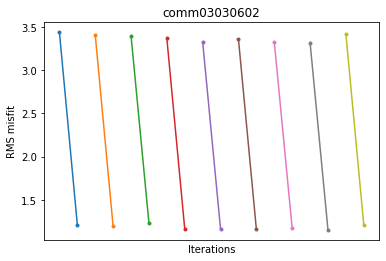

In [7]:
k.showRMS()

In [8]:
res0 = k.meshResults[0].df['Resistivity'].values
for m in k.meshResults[1:]:
    m.df['difference(percent)'] = (m.df['Resistivity'] - res0)/res0 * 100

C:\Users\gblanchy\WPy64-3890\python-3.8.9.amd64\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'Resistivity'

In [ ]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='Resistivity', index=0, 
              zlim=[-15, 0], pvslices=[[4],[5],[-5,-10,-15]], vmin=0, vmax=500)

In [ ]:
pl = pv.Plotter()
k.showResults(ax=pl, attr='difference(percent)', index=5, 
              zlim=[-15, 0], pvslices=[[4],[5],[-5,-10,-15]], vmin=-5, vmax=7)

In [ ]:
pl = pv.Plotter(shape=(3,3))
for i in range(3):
    for j in range(3):
        if i*3+j > 7:
            break
        pl.subplot(i, j)
        pl.add_text('Day {:d}'.format(i*3+j+1))
        k.showResults(index=i*3+j+1, ax=pl, attr='difference(percent)', background_color=(1,1,1),
                      zlim=[-15, 0], vmin=-5, vmax=5, pvcontour=[7.5], pvshow=False)
        # we need pvshow == False to build subplots(), this prevent calling Plotter.show()
        # after each scene
pl.show()

In [ ]:
# graph
wd = k.dirname + '/'
a = 15
p = pv.Plotter(notebook=True)
for i in range(8):
    mesh = pv.read(wd + 'f{:03d}_res.vtk'.format(i+1))
    mesh.translate([a*i, 0, 0])
    p.add_mesh(mesh, scalars='Resistivity', cmap='viridis')
    melec = pv.PolyData(k.elec[['x','y','z']].values)
    melec.translate([a*i, 0, 0])
    p.add_mesh(melec)
p.view_xz()
p.show()
# add annotation